In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [58]:
# Load and preprocess data
malData = pd.read_csv("/MalwareData.csv.gz", sep="|")
legit = malData[0:41323].drop(["legitimate"], axis=1)
mal = malData[41323::].drop(["legitimate"], axis=1)
print("Legit shape:", legit.shape)
print("Malware shape:", mal.shape)

Legit shape: (41323, 56)
Malware shape: (96724, 56)


In [59]:
# Feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

labels = malData['legitimate'].values
data_in = malData.drop(['Name', 'md5', 'legitimate'], axis=1).values
extratrees = ExtraTreesClassifier().fit(data_in, labels)
select = SelectFromModel(extratrees, prefit=True)
data_in_new = select.transform(data_in)


In [60]:
# Feature importance
importances = extratrees.feature_importances_
indices = np.argsort(importances)[::-1]


In [61]:
# Train-test split
from sklearn.model_selection import train_test_split
legit_train, legit_test, mal_train, mal_test = train_test_split(data_in_new, labels, test_size=0.2, random_state=42)


In [62]:
# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [63]:
# Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(legit_train, mal_train)
rf_score = rf.score(legit_test, mal_test) * 100


In [64]:
# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=50, random_state=42)
gb.fit(legit_train, mal_train)
gb_score = gb.score(legit_test, mal_test) * 100

In [65]:
# XGBoost
xgb = XGBClassifier(n_estimators=50, eval_metric='logloss', random_state=42)
xgb.fit(legit_train, mal_train)
xgb_score = xgb.score(legit_test, mal_test) * 100


In [66]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(legit_train, mal_train)
dt_score = dt.score(legit_test, mal_test) * 100

In [68]:
# Naive Bayes
nb = GaussianNB()
nb.fit(legit_train, mal_train)
b_score = nb.score(legit_test, mal_test) * 100

In [69]:
# SVM
svm = SVC()
svm.fit(legit_train, mal_train)
svm_score = svm.score(legit_test, mal_test) * 100

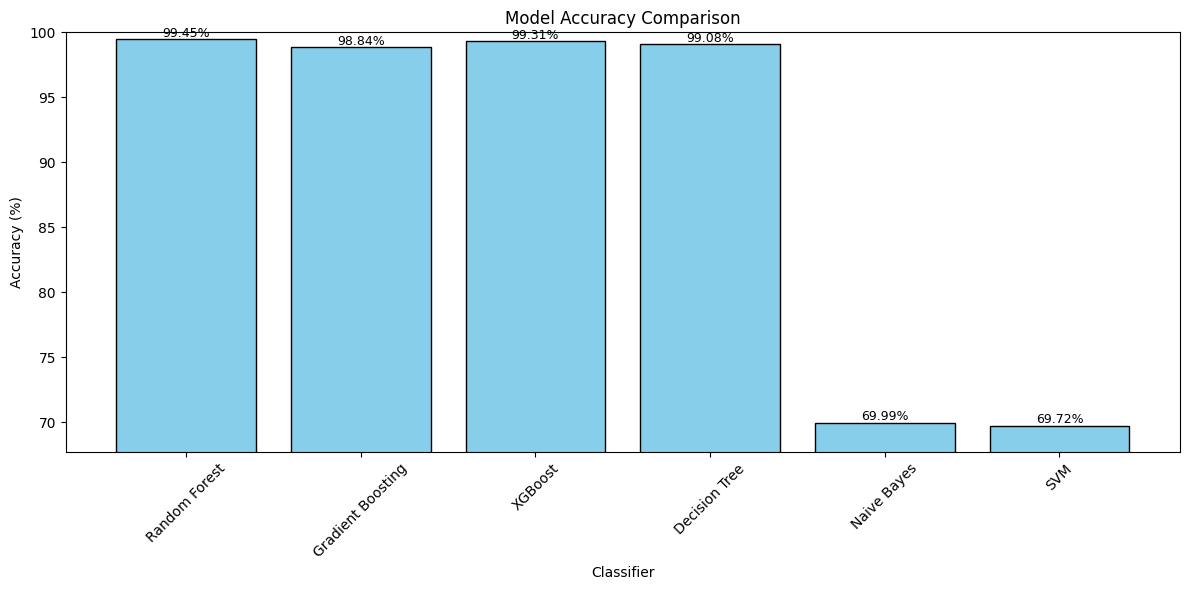

In [70]:
# Accuracy comparison plot
model_names = ["Random Forest", "Gradient Boosting", "XGBoost", "Decision Tree", "Naive Bayes", "SVM"]
model_scores = [rf_score, gb_score, xgb_score, dt_score, nb_score, svm_score]

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, model_scores, color='skyblue', edgecolor='black')
plt.xlabel("Classifier")
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(min(model_scores) - 2, 100)
for bar, score in zip(bars, model_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2, f"{score:.2f}%", ha='center', fontsize=9)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

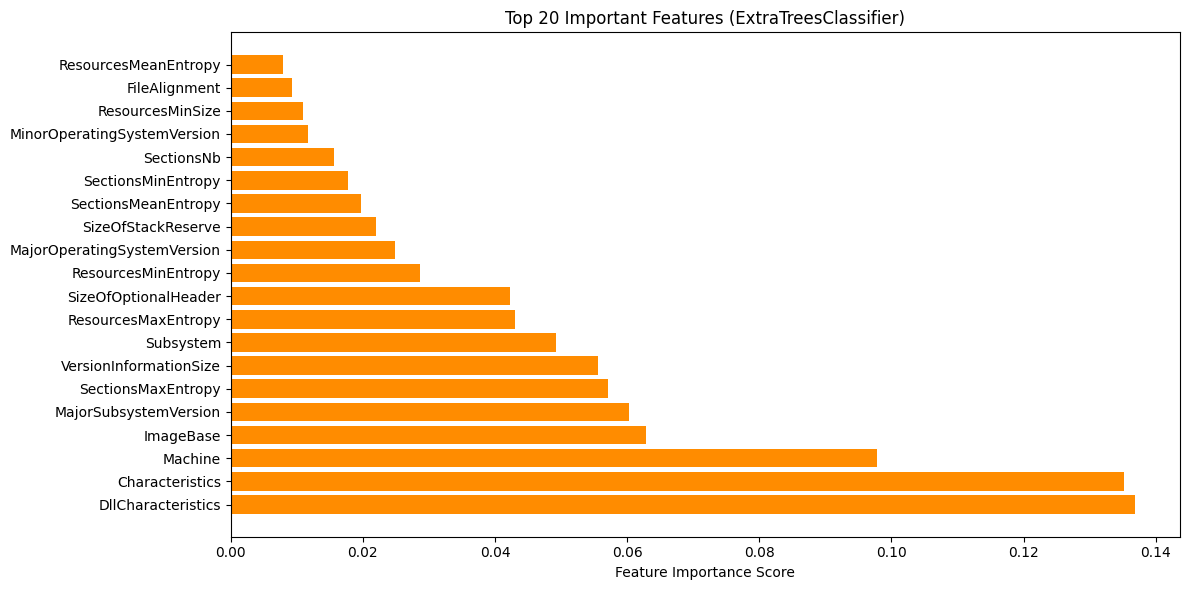

In [71]:
# Feature importance plot (ExtraTreesClassifier)
top_n = 20
top_features = indices[:top_n]
top_importances = importances[top_features]
feature_names = malData.drop(['Name', 'md5', 'legitimate'], axis=1).columns
top_feature_names = [feature_names[i] for i in top_features]

plt.figure(figsize=(12, 6))
plt.barh(range(top_n), top_importances[::-1], align='center', color='darkorange')
plt.yticks(range(top_n), top_feature_names[::-1])
plt.xlabel("Feature Importance Score")
plt.title("Top 20 Important Features (ExtraTreesClassifier)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

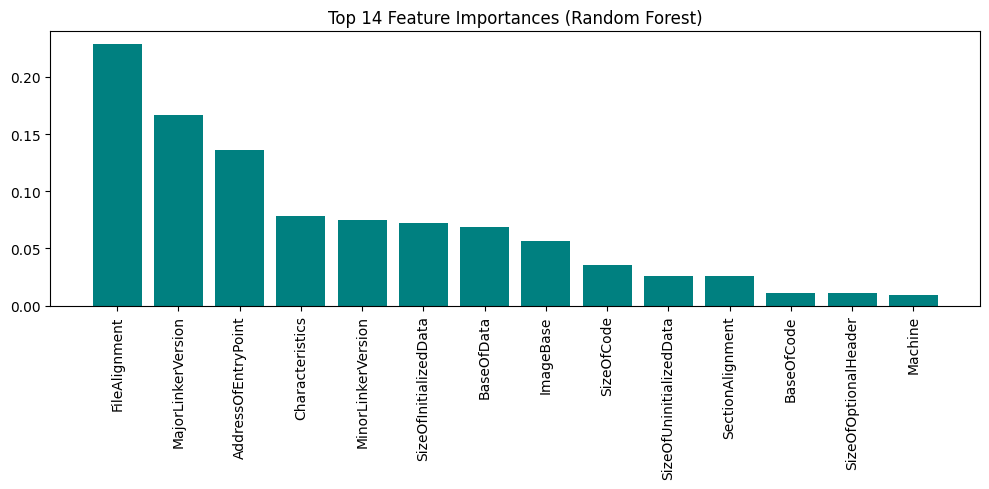

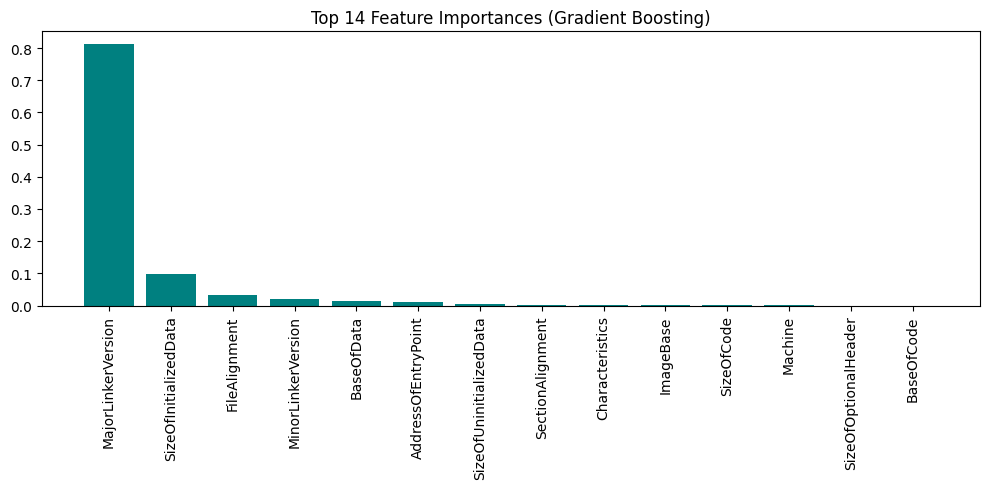

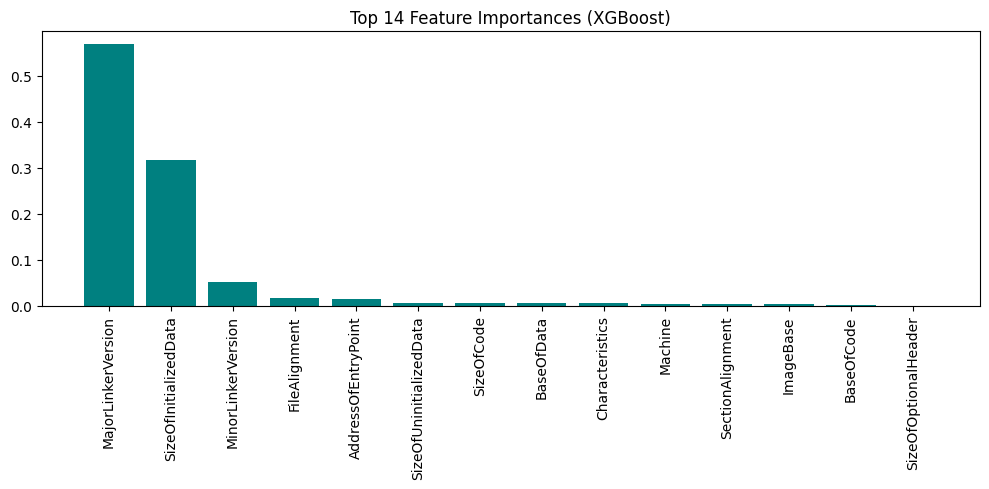

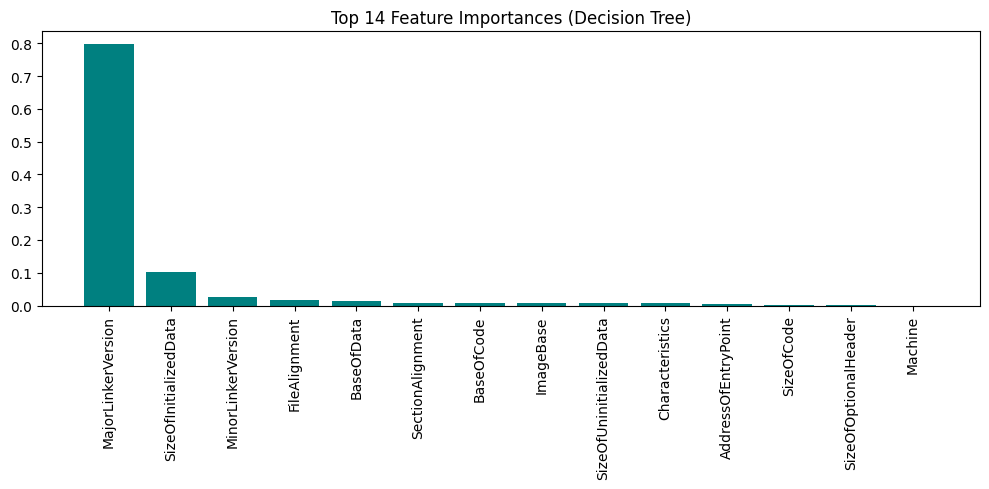

In [73]:
# Feature importance for each classifier (bar plot for comparison)
model_objects = [rf, gb, xgb, dt]
model_labels = ["Random Forest", "Gradient Boosting", "XGBoost", "Decision Tree"]

for model, label in zip(model_objects, model_labels):
    importances = model.feature_importances_
    model_top_n = min(top_n, len(importances))  # ensure we don't exceed available features
    indices = np.argsort(importances)[::-1][:model_top_n]

    plt.figure(figsize=(10, 5))
    plt.title(f"Top {model_top_n} Feature Importances ({label})")
    plt.bar(range(model_top_n), importances[indices], color='teal', align='center')
    plt.xticks(range(model_top_n), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()